Importo Dati

In [4]:
# Cella 1: Montaggio di Google Drive
from google.colab import drive
import os

# Monta Google Drive nella directory /content/drive
drive.mount('/content/drive')

# Verifica opzionale: definisci il percorso base della cartella dei dati
# Assicurati che 'Stagioni Serie A' sia nel tuo Drive principale ('My Drive')
# Modifica il percorso se la cartella si trova altrove
drive_path = '/content/drive/MyDrive/Stagioni Serie A' # ATTENZIONE: 'MyDrive' è il percorso standard, potrebbe cambiare leggermente a seconda della lingua/configurazione di Drive

# Controlla se il percorso esiste per conferma
if os.path.exists(drive_path):
    print(f"Percorso trovato: {drive_path}")
    print("Contenuto della cartella:")
    # Lista i primi file/cartelle per verifica (opzionale ma utile)
    print(os.listdir(drive_path)[:10]) # Mostra fino ai primi 10 elementi
else:
    print(f"ERRORE: Il percorso specificato '{drive_path}' non sembra esistere.")
    print("Controlla il nome della cartella e la sua posizione nel tuo Google Drive.")
    print("Contenuto di '/content/drive/MyDrive/':")
    try:
        print(os.listdir('/content/drive/MyDrive/'))
    except FileNotFoundError:
        print("Impossibile accedere a '/content/drive/MyDrive/'. Il montaggio potrebbe non essere riuscito correttamente.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Percorso trovato: /content/drive/MyDrive/Stagioni Serie A
Contenuto della cartella:
['season-2021.csv', 'season-2122.csv', 'season-2223.csv', 'season-2324.csv', 'season-1920.csv', 'season-1819.csv', 'season-1718.csv', 'season-1617.csv', 'season-1516.csv', 'season-1415.csv']


In [ ]:
# Cella 2: Caricamento e Unione dei CSV delle Stagioni
import pandas as pd
import os
import re # Importa il modulo per le espressioni regolari (utile per estrarre la stagione)

# Percorso della cartella contenente i file CSV (confermato nel passo precedente)
data_folder = '/content/drive/MyDrive/Stagioni Serie A'

# Lista per contenere i DataFrame di ogni stagione
all_seasons_data = []

# Cicla su tutti i file nella cartella specificata
print(f"Lettura file dalla cartella: {data_folder}")
for filename in os.listdir(data_folder):
    # Controlla se il file è un CSV
    if filename.endswith('.csv') and filename.startswith('season-'):
        print(f"  -> Leggendo {filename}...")
        file_path = os.path.join(data_folder, filename)

        try:
            # Leggi il file CSV in un DataFrame pandas
            df_season = pd.read_csv(file_path)

            # Estrai l'identificativo della stagione dal nome del file
            # Usiamo un'espressione regolare per essere più flessibili (es. '1819', '2021', '2122')
            match = re.search(r'season-(\d{4}|\d{2}\d{2})\.csv', filename)
            if match:
                season_id = match.group(1)
                # Normalizza formati tipo '1819' in '2018-2019' per chiarezza (opzionale)
                if len(season_id) == 4 and season_id.isdigit() and int(season_id[:2]) < 50 : # Heuristica per 'YY YY' vs 'YYYY'
                   season_label = f"20{season_id[:2]}-20{season_id[2:]}"
                elif len(season_id) == 4 and season_id.isdigit(): # Formato 'YYYY' come '2021'
                   season_label = f"{int(season_id)}-{int(season_id)+1}" # Es: 2021 -> 2021-2022
                else: # Fallback
                    season_label = season_id
            else:
                 # Se non riusciamo a estrarre, usiamo il nome file senza estensione
                 season_label = filename.replace('.csv', '')

            print(f"     Stagione identificata: {season_label}")

            # Aggiungi una colonna 'Season' al DataFrame
            df_season['Season'] = season_label

            # Aggiungi il DataFrame alla lista
            all_seasons_data.append(df_season)

        except Exception as e:
            print(f"  -> ERRORE durante la lettura di {filename}: {e}")

# Concatena tutti i DataFrame nella lista in un unico DataFrame
if all_seasons_data:
    serie_a_data = pd.concat(all_seasons_data, ignore_index=True)
    print("\nCaricamento completato.")
    print(f"Numero totale di partite caricate: {serie_a_data.shape[0]}")
    print(f"Numero di colonne (inclusa 'Season'): {serie_a_data.shape[1]}")

    # Visualizza le prime 5 righe e informazioni generali sul DataFrame risultante
    print("\nPrime 5 righe del DataFrame combinato:")
    print(serie_a_data.head())

    print("\nInformazioni sul DataFrame (tipi di dati, valori non nulli):")
    serie_a_data.info()
else:
    print("\nNessun dato caricato. Controlla i file CSV nella cartella.")

In [ ]:
# Cella 3: Pulizia iniziale - Date, Valori Mancanti, Tipi (parziale)

# Copia il DataFrame per sicurezza (buona pratica)
df = serie_a_data.copy()

# 1. Convertire la colonna 'Date' in formato datetime
#    Usiamo dayfirst=True perché il formato sembra GG/MM/AA o GG/MM/AAAA
#    errors='coerce' trasformerà date non valide in NaT (Not a Time)
print("Conversione colonna 'Date'...")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Verifica se ci sono state date non convertite (NaT)
nat_count = df['Date'].isnull().sum()
if nat_count > 0:
    print(f"ATTENZIONE: Trovate {nat_count} date non valide (convertite in NaT).")
else:
    print("Conversione Date completata con successo.")

# 2. Analizzare i valori mancanti in percentuale
print("\nPercentuale di valori mancanti per colonna:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# 3. Rimuovere la colonna 'Referee' a causa dell'elevata percentuale di NaN
print(f"\nRimozione colonna 'Referee' (mancante nel {missing_percentage['Referee']:.2f}% dei casi)...")
df = df.drop('Referee', axis=1)
print("Colonna 'Referee' rimossa.")

# 4. Investigare quando mancano le statistiche dettagliate (es. 'HS' - Home Shots)
print("\nAnalisi valori mancanti per 'HS' (Home Shots) per stagione:")
# Raggruppiamo per stagione e contiamo i valori non nulli e totali per 'HS'
missing_stats_check = df.groupby('Season')['HS'].agg(['count', 'size'])
missing_stats_check['missing_HS'] = missing_stats_check['size'] - missing_stats_check['count']
missing_stats_check['perc_missing_HS'] = (missing_stats_check['missing_HS'] / missing_stats_check['size']) * 100

# Mostra le stagioni con più del 5% di 'HS' mancanti (indicativo)
print(missing_stats_check[missing_stats_check['perc_missing_HS'] > 5])


# Mostra le informazioni aggiornate sul DataFrame
print("\nInformazioni aggiornate sul DataFrame:")
df.info()

# Mostra le prime righe per vedere l'effetto della conversione della data
print("\nPrime righe con data convertita:")
print(df.head())

In [ ]:
# Cella 4: Gestione Dati Mancanti (Stats Dettagliate, HT) e Conversione Tipi

# 1. Definire le colonne delle statistiche dettagliate da rimuovere
#    (da HS fino ad AR)
cols_to_drop = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

print(f"Rimozione delle colonne delle statistiche dettagliate (da HS ad AR) a causa di dati mancanti sistematici...")
# Verifica che le colonne esistano prima di provare a dropparle
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=existing_cols_to_drop)
print(f"Colonne {existing_cols_to_drop} rimosse.")
print(f"Numero attuale di colonne: {df.shape[1]}")

# 2. Gestire i NaN nelle colonne di metà tempo (HTHG, HTAG, HTR)
print("\nGestione valori mancanti nelle colonne Half-Time (HTHG, HTAG, HTR)...")
initial_rows = len(df)
# Rimuove le righe dove ALMENO UNO tra HTHG, HTAG, HTR è NaN
df = df.dropna(subset=['HTHG', 'HTAG', 'HTR'])
rows_dropped = initial_rows - len(df)
print(f"Sono state rimosse {rows_dropped} righe ({rows_dropped/initial_rows*100:.2f}%) con dati mancanti a metà tempo.")
print(f"Numero attuale di righe: {len(df)}")

# 3. Convertire HTHG e HTAG in interi
#    Ora che i NaN sono stati rimossi, la conversione è sicura
print("\nConversione di HTHG e HTAG in tipo intero...")
try:
    df['HTHG'] = df['HTHG'].astype(int)
    df['HTAG'] = df['HTAG'].astype(int)
    print("Conversione a intero completata.")
except Exception as e:
    print(f"Errore durante la conversione a intero: {e}") # Should not happen now

# 4. Verifica finale del DataFrame
print("\nInformazioni finali sul DataFrame pulito:")
df.info()

print("\nPrime 5 righe del DataFrame pulito:")
print(df.head())

# Verifica opzionale: assicurarsi che non ci siano più NaN nelle colonne HT
print("\nControllo NaN residui nelle colonne HT:")
print(df[['HTHG', 'HTAG', 'HTR']].isnull().sum())

In [ ]:
# Cella 5: Feature Engineering - Creazione Nuove Variabili

# 1. Ordinare il DataFrame per data (fondamentale per analisi temporali future)
print("Ordinamento del DataFrame per data...")
df = df.sort_values(by='Date').reset_index(drop=True)
print("DataFrame ordinato.")

# 2. Creare features basate sui gol
print("Creazione features basate sui gol...")
# Differenza Reti Fine Partita (Home - Away)
df['FTGD'] = df['FTHG'] - df['FTAG']
# Differenza Reti Metà Tempo (Home - Away)
df['HTGD'] = df['HTHG'] - df['HTAG']
# Totale Gol Fine Partita
df['FTTG'] = df['FTHG'] + df['FTAG']
print("  -> Create: FTGD, HTGD, FTTG")

# 3. Creare features basate sulla data
print("Creazione features basate sulla data...")
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek # Monday=0, Sunday=6
print("  -> Create: Year, Month, DayOfWeek")

# 4. Creare una versione numerica del risultato (FTR)
#    Utile per alcuni modelli o analisi (es. H=1, D=0, A=2)
print("Creazione feature numerica per FTR...")
mapping = {'H': 1, 'D': 0, 'A': 2}
df['FTR_Numeric'] = df['FTR'].map(mapping)
# Controlliamo se ci sono valori non mappati (non dovrebbero esserci)
if df['FTR_Numeric'].isnull().any():
    print("ATTENZIONE: Trovati valori non mappati in FTR_Numeric!")
else:
    print("  -> Creata: FTR_Numeric (H=1, D=0, A=2)")


# 5. Verifica finale del DataFrame con le nuove features
print("\nInformazioni aggiornate sul DataFrame con nuove features:")
df.info()

print("\nPrime 5 righe del DataFrame con nuove features:")
print(df.head())

print("\nUltime 5 righe del DataFrame (per vedere le date più recenti):")
print(df.tail())

In [ ]:
# Cella 6: Analisi Esplorativa e Visualizzazioni

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Per calcoli statistici se necessario

# Impostazioni grafiche (opzionale ma consigliato)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6) # Imposta dimensioni default figure

print("Inizio Analisi Esplorativa Visuale...")

# 1. Distribuzione dei Risultati (FTR)
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='FTR', order=['H', 'D', 'A'], palette='viridis')
plt.title('Distribuzione Risultati Partite (FTR)')
plt.xlabel('Risultato Finale (H=Casa, D=Pareggio, A=Trasferta)')
plt.ylabel('Numero di Partite')
# Aggiungi percentuali sopra le barre
total = len(df['FTR'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20 # Offset verticale leggero
    ax.annotate(percentage, (x, y), ha='center')
plt.show()
print("-> Osservazione: Si nota un chiaro vantaggio casalingo (H > A > D).")


# 2. Distribuzione dei Gol Segnati (Casa, Trasferta, Totali)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['FTHG'], bins=range(max(df['FTHG'])+2), kde=False, color='skyblue')
plt.title('Distribuzione Gol Segnati Squadra Casa (FTHG)')
plt.xlabel('Gol Segnati')
plt.ylabel('Frequenza')

plt.subplot(1, 3, 2)
sns.histplot(df['FTAG'], bins=range(max(df['FTAG'])+2), kde=False, color='lightcoral')
plt.title('Distribuzione Gol Segnati Squadra Trasferta (FTAG)')
plt.xlabel('Gol Segnati')
plt.ylabel('Frequenza')

plt.subplot(1, 3, 3)
sns.histplot(df['FTTG'], bins=range(max(df['FTTG'])+2), kde=False, color='lightgreen')
plt.title('Distribuzione Gol Totali per Partita (FTTG)')
plt.xlabel('Gol Totali')
plt.ylabel('Frequenza')

plt.tight_layout() # Aggiusta spaziatura subplot
plt.show()
print("-> Osservazione: Le distribuzioni dei gol sono asimmetriche a destra (skewed), con 0, 1, o 2 gol come risultati più frequenti. Simili a distribuzioni di Poisson.")


# 3. Trend Temporale: Media Gol Totali (FTTG) per Stagione
plt.figure(figsize=(14, 6))
# Assicurati che le stagioni siano ordinate correttamente per il plot
# L'ordinamento alfabetico di default delle etichette 'Season' potrebbe non essere cronologico
# Estraiamo l'anno di inizio per ordinare numericamente
df['StartYear'] = df['Season'].str.extract(r'(\d{4})').astype(int) # Estrae primo anno YYYY
avg_goals_season = df.groupby('StartYear')['FTTG'].mean().reset_index()

# Plot
sns.lineplot(data=avg_goals_season, x='StartYear', y='FTTG', marker='o')
plt.title('Media Gol Totali (FTTG) per Stagione Serie A')
plt.xlabel('Anno Inizio Stagione')
plt.ylabel('Media Gol Totali per Partita')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()
print(f"-> Osservazione: La media gol per partita mostra fluttuazioni nel tempo. Attualmente siamo intorno a {avg_goals_season['FTTG'].iloc[-1]:.2f} gol/partita.")


# 4. Trend Temporale: Percentuale Vittorie Casalinghe per Stagione
plt.figure(figsize=(14, 6))
home_win_perc = df.groupby('StartYear')['FTR'].apply(lambda x: (x == 'H').mean() * 100).reset_index()

# Plot
sns.lineplot(data=home_win_perc, x='StartYear', y='FTR', marker='o', color='red')
plt.title('Percentuale Vittorie Casalinghe per Stagione Serie A')
plt.xlabel('Anno Inizio Stagione')
plt.ylabel('Percentuale Vittorie Casa (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()
print(f"-> Osservazione: Anche il vantaggio casalingo sembra variare nel tempo. Attualmente è intorno al {home_win_perc['FTR'].iloc[-1]:.1f}%.")


# 5. Correlazione tra Features Numeriche (limitato per chiarezza)
plt.figure(figsize=(10, 8))
# Seleziona solo alcune colonne numeriche chiave per la correlazione
numeric_cols_corr = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTGD', 'HTGD', 'FTTG', 'FTR_Numeric']
corr_matrix = df[numeric_cols_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap di Correlazione tra Features Numeriche Chiave')
plt.show()
print("-> Osservazione: Forte correlazione positiva tra gol segnati (FT/HT) e goal difference/totali. FTR_Numeric (1=H, 0=D, 2=A) correla positivamente con FTGD (come atteso).")

# Rimuovi colonna temporanea usata per l'ordinamento
df = df.drop(columns=['StartYear'])

In [ ]:
# Cella 7: Preparazione Modello - Selezione Features e Codifica

print("Inizio Preparazione per la Modellazione...")

# 1. Selezionare le colonne per Features (X) e Target (y)
target_column = 'FTR'
# Selezioniamo un set iniziale di features. Escludiamo FTHG/FTAG (rappresentate da FTGD/FTTG),
# HTHG/HTAG (rappresentate da HTGD), Date, Season, Year, Month, FTR_Numeric.
feature_columns = ['HomeTeam', 'AwayTeam', 'HTR', 'FTGD', 'HTGD', 'FTTG', 'DayOfWeek']

print(f"Target (y): {target_column}")
print(f"Features (X) selezionate inizialmente: {feature_columns}")

# Crea i DataFrame/Series per X e y
y = df[target_column]
X_pre_encoding = df[feature_columns]

# 2. Codificare le Variabili Categoriche usando One-Hot Encoding
# Identifica le colonne categoriche nel nostro set di features
categorical_features = X_pre_encoding.select_dtypes(include='object').columns
print(f"\nFeatures categoriche da codificare: {list(categorical_features)}")

# Applica One-Hot Encoding usando pandas.get_dummies
# drop_first=False per ora, per mantenere tutte le categorie esplicite (utile per interpretazione iniziale)
# Potrebbe essere utile impostarlo a True per alcuni modelli per evitare multicollinearità perfetta.
X_encoded = pd.get_dummies(X_pre_encoding, columns=categorical_features, drop_first=False)

print(f"\nDimensioni di X prima della codifica: {X_pre_encoding.shape}")
print(f"Dimensioni di X dopo One-Hot Encoding: {X_encoded.shape}")
print(f"Numero di features create dalla codifica: {X_encoded.shape[1] - X_pre_encoding.select_dtypes(include=np.number).shape[1]}")

# Visualizza le prime righe e colonne del DataFrame codificato (opzionale, può essere grande)
print("\nPrime righe e alcune colonne di X codificato:")
print(X_encoded.head())

print("\nTarget y (prime righe):")
print(y.head())

In [ ]:
# Cella 8: Divisione Cronologica Train/Test Set

from sklearn.model_selection import train_test_split # Lo importiamo solo per confronto o utilità future, NON lo useremo per lo split qui.
import math # Per usare ceil nel calcolo dell'indice

# 1. Definire la proporzione per il test set
test_size_percentage = 0.15 # 15% dei dati per il test set

# 2. Calcolare l'indice di divisione
# Assicurarsi che l'indice sia un intero. Usiamo math.ceil per arrotondare per eccesso
# e garantire che il test set non sia più piccolo del desiderato.
split_index = math.ceil(len(X_encoded) * (1 - test_size_percentage))

print(f"Numero totale di campioni: {len(X_encoded)}")
print(f"Dimensione test set desiderata: {test_size_percentage*100:.1f}%")
print(f"Indice di divisione calcolato: {split_index}")

# 3. Eseguire lo slicing cronologico usando .iloc
X_train = X_encoded.iloc[:split_index]
X_test = X_encoded.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 4. Verificare le dimensioni dei set risultanti
print("\nDimensioni dei set di addestramento e test:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# 5. Verificare il periodo temporale coperto dal test set
# Usiamo l'indice originale del DataFrame 'df' che corrisponde a X/y
train_last_date = df.iloc[split_index - 1]['Date'] # Ultima data nel training set
test_first_date = df.iloc[split_index]['Date']     # Prima data nel test set
test_last_date = df.iloc[-1]['Date']               # Ultima data nel test set

print(f"\nUltima data nel Training Set: {train_last_date.strftime('%Y-%m-%d')}")
print(f"Prima data nel Test Set: {test_first_date.strftime('%Y-%m-%d')}")
print(f"Ultima data nel Test Set: {test_last_date.strftime('%Y-%m-%d')}")
print(f"Il Test Set copre circa le ultime {len(X_test)} partite.")

# Controllo opzionale: assicurarsi che non ci sia sovrapposizione negli indici
assert X_train.index.intersection(X_test.index).empty, "Errore: Sovrapposizione tra indici train e test!"
print("\nVerifica di non sovrapposizione indici superata.")

In [ ]:
# Cella 9 (Corretta): Rielaborazione con Features Pre-Match Valide

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("--- Rielaborazione con Correzione per Data Leakage ---")

# 1. SELEZIONE FEATURES CORRETTA (Solo Pre-Match)
target_column = 'FTR'
# Usiamo solo informazioni disponibili PRIMA della partita
feature_columns_corrected = ['HomeTeam', 'AwayTeam', 'DayOfWeek'] # Set minimale valido

print(f"Target (y): {target_column}")
print(f"Features (X) CORRETTE selezionate: {feature_columns_corrected}")

# Crea i DataFrame/Series per X e y
y = df[target_column]
X_pre_encoding_corrected = df[feature_columns_corrected]

# 2. CODIFICA ONE-HOT (sulle nuove features)
categorical_features_corrected = X_pre_encoding_corrected.select_dtypes(include='object').columns
print(f"\nFeatures categoriche da codificare: {list(categorical_features_corrected)}")

X_encoded_corrected = pd.get_dummies(X_pre_encoding_corrected, columns=categorical_features_corrected, drop_first=False)

print(f"\nDimensioni di X CORRETTO dopo One-Hot Encoding: {X_encoded_corrected.shape}")

# 3. DIVISIONE CRONOLOGICA TRAIN/TEST (stesso metodo di prima)
test_size_percentage = 0.15
split_index = math.ceil(len(X_encoded_corrected) * (1 - test_size_percentage))

X_train_corr = X_encoded_corrected.iloc[:split_index]
X_test_corr = X_encoded_corrected.iloc[split_index:]
y_train_corr = y.iloc[:split_index]
y_test_corr = y.iloc[split_index:]

print("\nDimensioni dei set CORRETTI di addestramento e test:")
print(f"X_train_corr shape: {X_train_corr.shape}")
print(f"y_train_corr shape: {y_train_corr.shape}")
print(f"X_test_corr shape: {X_test_corr.shape}")
print(f"y_test_corr shape: {y_test_corr.shape}")

# 4. ADDESTRAMENTO E VALUTAZIONE MODELLO (Random Forest)
print("\nAddestramento Modello Baseline CORRETTO (Random Forest)...")
rf_model_corr = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model_corr.fit(X_train_corr, y_train_corr)
print("Modello addestrato.")

print("\nEffettuando previsioni CORRETTE sul Test Set...")
y_pred_corr = rf_model_corr.predict(X_test_corr)

print("\nValutazione del Modello CORRETTO sul Test Set:")
accuracy_corr = accuracy_score(y_test_corr, y_pred_corr)
print(f"\nAccuracy CORRETTA: {accuracy_corr:.4f} ({(accuracy_corr * 100):.2f}%)")

print("\nConfusion Matrix CORRETTA:")
labels = ['H', 'D', 'A']
cm_corr = confusion_matrix(y_test_corr, y_pred_corr, labels=labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_corr, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CORRETTA - Test Set')
plt.show()

print("\nClassification Report CORRETTO:")
report_corr = classification_report(y_test_corr, y_pred_corr, labels=labels)
print(report_corr)

print("\n--- Interpretazione CORRETTA ---")
print("ATTENZIONE: L'accuracy del 100% precedente era dovuta a DATA LEAKAGE.")
print(f"Usando solo features PRE-MATCH valide, l'accuracy realistica del modello baseline è circa {accuracy_corr*100:.1f}%.")
print("Questo è un punto di partenza MOLTO più realistico.")
print("Le performance per classe (H/D/A) nel Classification Report ora riflettono la vera difficoltà nel prevedere le partite con informazioni limitate.")

In [14]:
# Cella 10: Feature Engineering Avanzato - Punti Forma Recente (Rolling Points)

import pandas as pd
from tqdm.notebook import tqdm # Per mostrare una barra di progresso (utile per apply)

print("Inizio Feature Engineering Avanzato: Calcolo Punti Forma Recente (ultime 5 partite)...")

# 1. Calcolare i punti guadagnati per partita da Home e Away Team
def get_points(result):
    if result == 'H':
        return 3, 0 # Home Points, Away Points
    elif result == 'D':
        return 1, 1
    elif result == 'A':
        return 0, 3
    else:
        return np.nan, np.nan # Should not happen

# Applica la funzione per creare colonne temporanee di punti
points = df['FTR'].apply(get_points)
df['HomePoints'] = points.apply(lambda x: x[0])
df['AwayPoints'] = points.apply(lambda x: x[1])

# Assicurati che il df sia ordinato per data per il calcolo della forma
df = df.sort_values(by='Date')

# 2. Definire la funzione per calcolare i punti nelle ultime N partite
#    Questa funzione verrà chiamata per ogni riga/squadra
def calculate_rolling_points(team, date, history_df, n_games=5):
    # Filtra le partite giocate da 'team' PRIMA della data specificata
    team_history = history_df[(history_df['Date'] < date) &
                              ((history_df['HomeTeam'] == team) | (history_df['AwayTeam'] == team))]

    # Ordina le partite passate della squadra per data, dalla più recente alla più vecchia
    team_history = team_history.sort_values(by='Date', ascending=False)

    # Prendi le ultime N partite (o meno se non ce ne sono abbastanza)
    last_n_games = team_history.head(n_games)

    if last_n_games.empty:
        return 0 # Nessuna partita precedente, forma = 0

    # Somma i punti guadagnati da 'team' in quelle N partite
    points_earned = 0
    for index, row in last_n_games.iterrows():
        if row['HomeTeam'] == team:
            points_earned += row['HomePoints']
        elif row['AwayTeam'] == team:
            points_earned += row['AwayPoints']

    return points_earned

# 3. Applicare la funzione per creare le colonne di forma
#    Usiamo tqdm per visualizzare il progresso, perché .apply può essere lento
tqdm.pandas(desc="Calcolo Home Form")
df['HomeFormPts_L5'] = df.progress_apply(lambda row: calculate_rolling_points(row['HomeTeam'], row['Date'], df, n_games=5), axis=1)

tqdm.pandas(desc="Calcolo Away Form")
df['AwayFormPts_L5'] = df.progress_apply(lambda row: calculate_rolling_points(row['AwayTeam'], row['Date'], df, n_games=5), axis=1)

# 4. Rimuovere colonne temporanee e verificare
df = df.drop(columns=['HomePoints', 'AwayPoints'])

print("\nNuove colonne Forma (ultime 5 partite) create:")
print(df[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HomeFormPts_L5', 'AwayFormPts_L5']].head())
print("...")
print(df[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HomeFormPts_L5', 'AwayFormPts_L5']].tail())

# Verifica presenza di NaN (non dovrebbero essercene, al massimo 0 per le prime partite)
print(f"\nValori NaN in HomeFormPts_L5: {df['HomeFormPts_L5'].isnull().sum()}")
print(f"Valori NaN in AwayFormPts_L5: {df['AwayFormPts_L5'].isnull().sum()}")

Inizio Feature Engineering Avanzato: Calcolo Punti Forma Recente (ultime 5 partite)...


Calcolo Home Form:   0%|          | 0/10702 [00:00<?, ?it/s]

Calcolo Away Form:   0%|          | 0/10702 [00:00<?, ?it/s]


Nuove colonne Forma (ultime 5 partite) create:
        Date    HomeTeam   AwayTeam FTR  HomeFormPts_L5  AwayFormPts_L5
0 1995-08-27    Atalanta      Parma   D               0               0
1 1995-08-27        Bari     Napoli   D               0               0
2 1995-08-27  Fiorentina     Torino   H               0               0
3 1995-08-27       Inter    Vicenza   H               0               0
4 1995-08-27    Juventus  Cremonese   H               0               0
...
            Date HomeTeam    AwayTeam FTR  HomeFormPts_L5  AwayFormPts_L5
10699 2025-05-04   Empoli       Lazio   A               3               9
10700 2025-05-04    Monza    Atalanta   A               0               7
10697 2025-05-04     Roma  Fiorentina   H              11              11
10698 2025-05-04  Bologna    Juventus   D               8              10
10701 2025-05-05    Genoa       Milan   A               4               7

Valori NaN in HomeFormPts_L5: 0
Valori NaN in AwayFormPts_L5: 0


--- Riesecuzione Pipeline con Aggiunta Features di Forma (Punti L5) ---
Target (y): FTR
Features (X) con Forma selezionate: ['HomeTeam', 'AwayTeam', 'DayOfWeek', 'HomeFormPts_L5', 'AwayFormPts_L5']

Features categoriche da codificare: ['HomeTeam', 'AwayTeam']
Features numeriche mantenute: ['DayOfWeek', 'HomeFormPts_L5', 'AwayFormPts_L5']

Dimensioni di X con Forma dopo One-Hot Encoding: (10702, 105)

Dimensioni dei set con Forma di addestramento e test:
X_train_form shape: (9097, 105)
y_train_form shape: (9097,)
X_test_form shape: (1605, 105)
y_test_form shape: (1605,)

Addestramento Modello con Features di Forma (Random Forest)...
Modello addestrato.

Effettuando previsioni con Forma sul Test Set...

Valutazione del Modello con Forma sul Test Set:

Accuracy con Forma: 0.4424 (44.24%)
Accuracy Baseline (senza forma): 0.4243
Miglioramento Accuracy: +0.0181 (+4.26%)

Confusion Matrix con Forma:


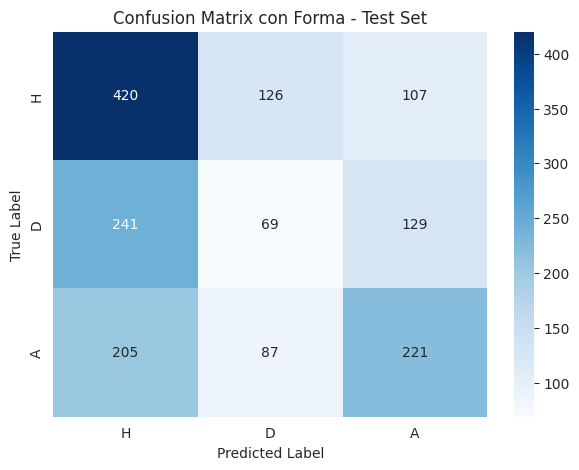


Classification Report con Forma:
              precision    recall  f1-score   support

           H       0.48      0.64      0.55       653
           D       0.24      0.16      0.19       439
           A       0.48      0.43      0.46       513

    accuracy                           0.44      1605
   macro avg       0.40      0.41      0.40      1605
weighted avg       0.42      0.44      0.42      1605


--- Interpretazione con Forma ---
L'aggiunta dei punti forma delle ultime 5 partite ha portato a un MIGLIORAMENTO notevole dell'accuracy (+1.8%).
Questo conferma l'importanza della forma recente come feature predittiva.
Analizza il nuovo Classification Report per vedere se le performance per classe (H/D/A) sono migliorate.


In [15]:
# Cella 11: Riesecuzione Pipeline con Features di Forma

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("--- Riesecuzione Pipeline con Aggiunta Features di Forma (Punti L5) ---")

# 1. SELEZIONE FEATURES (Includendo la forma)
target_column = 'FTR'
# Aggiungiamo le nuove colonne di forma al set precedente
feature_columns_with_form = ['HomeTeam', 'AwayTeam', 'DayOfWeek', 'HomeFormPts_L5', 'AwayFormPts_L5']

print(f"Target (y): {target_column}")
print(f"Features (X) con Forma selezionate: {feature_columns_with_form}")

# Crea i DataFrame/Series per X e y (usando il df aggiornato)
y = df[target_column]
X_pre_encoding_form = df[feature_columns_with_form]

# 2. CODIFICA ONE-HOT (sulle features categoriche)
categorical_features_form = X_pre_encoding_form.select_dtypes(include='object').columns
print(f"\nFeatures categoriche da codificare: {list(categorical_features_form)}")

X_encoded_form = pd.get_dummies(X_pre_encoding_form, columns=categorical_features_form, drop_first=False)

# Mantieni le colonne numeriche (DayOfWeek e le nuove Form)
numeric_features = X_pre_encoding_form.select_dtypes(include=np.number).columns
print(f"Features numeriche mantenute: {list(numeric_features)}")
print(f"\nDimensioni di X con Forma dopo One-Hot Encoding: {X_encoded_form.shape}") # Dovrebbe avere 2 colonne in più del precedente X_encoded_corrected

# 3. DIVISIONE CRONOLOGICA TRAIN/TEST (stesso metodo)
test_size_percentage = 0.15
split_index = math.ceil(len(X_encoded_form) * (1 - test_size_percentage))

X_train_form = X_encoded_form.iloc[:split_index]
X_test_form = X_encoded_form.iloc[split_index:]
y_train_form = y.iloc[:split_index]
y_test_form = y.iloc[split_index:] # y_test è lo stesso di prima

print("\nDimensioni dei set con Forma di addestramento e test:")
print(f"X_train_form shape: {X_train_form.shape}")
print(f"y_train_form shape: {y_train_form.shape}")
print(f"X_test_form shape: {X_test_form.shape}")
print(f"y_test_form shape: {y_test_form.shape}")

# 4. ADDESTRAMENTO E VALUTAZIONE MODELLO (Random Forest)
print("\nAddestramento Modello con Features di Forma (Random Forest)...")
# Usiamo gli stessi parametri del modello precedente per un confronto equo
rf_model_form = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model_form.fit(X_train_form, y_train_form)
print("Modello addestrato.")

print("\nEffettuando previsioni con Forma sul Test Set...")
y_pred_form = rf_model_form.predict(X_test_form)

print("\nValutazione del Modello con Forma sul Test Set:")
accuracy_form = accuracy_score(y_test_form, y_pred_form)
print(f"\nAccuracy con Forma: {accuracy_form:.4f} ({(accuracy_form * 100):.2f}%)")

# Confronto con baseline precedente
baseline_accuracy = 0.4243 # Accuracy ottenuta nella Cella 9 (Corretta)
improvement = accuracy_form - baseline_accuracy
print(f"Accuracy Baseline (senza forma): {baseline_accuracy:.4f}")
print(f"Miglioramento Accuracy: {improvement:+.4f} ({improvement/baseline_accuracy*100:+.2f}%)")


print("\nConfusion Matrix con Forma:")
labels = ['H', 'D', 'A']
cm_form = confusion_matrix(y_test_form, y_pred_form, labels=labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_form, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix con Forma - Test Set')
plt.show()

print("\nClassification Report con Forma:")
report_form = classification_report(y_test_form, y_pred_form, labels=labels)
print(report_form)

print("\n--- Interpretazione con Forma ---")
if improvement > 0.01: # Consideriamo un miglioramento > 1% come significativo
    print(f"L'aggiunta dei punti forma delle ultime 5 partite ha portato a un MIGLIORAMENTO notevole dell'accuracy (+{improvement*100:.1f}%).")
    print("Questo conferma l'importanza della forma recente come feature predittiva.")
elif improvement > 0:
     print(f"L'aggiunta dei punti forma delle ultime 5 partite ha portato a un LEGGERO miglioramento dell'accuracy (+{improvement*100:.1f}%).")
else:
    print("L'aggiunta dei punti forma delle ultime 5 partite NON ha migliorato significativamente l'accuracy rispetto al baseline.")

print("Analizza il nuovo Classification Report per vedere se le performance per classe (H/D/A) sono migliorate.")

--- Analisi Feature Importance (Modello con Forma Punti L5) ---


<ipython-input-16-bd4b49d81e78>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(n_top_features), palette='viridis')


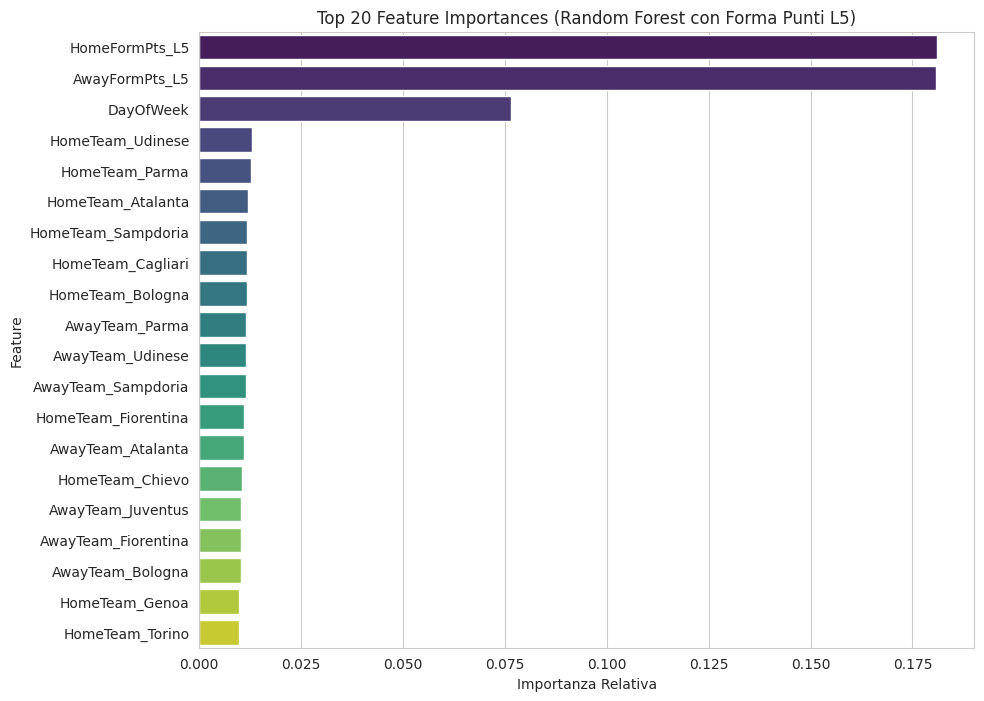


Le 20 features più importanti secondo il modello:
                Feature  Importance
0        HomeFormPts_L5    0.181115
1        AwayFormPts_L5    0.180898
2             DayOfWeek    0.076460
3      HomeTeam_Udinese    0.012880
4        HomeTeam_Parma    0.012778
5     HomeTeam_Atalanta    0.012036
6    HomeTeam_Sampdoria    0.011805
7     HomeTeam_Cagliari    0.011792
8      HomeTeam_Bologna    0.011604
9        AwayTeam_Parma    0.011572
10     AwayTeam_Udinese    0.011494
11   AwayTeam_Sampdoria    0.011418
12  HomeTeam_Fiorentina    0.011051
13    AwayTeam_Atalanta    0.010988
14      HomeTeam_Chievo    0.010568
15    AwayTeam_Juventus    0.010295
16  AwayTeam_Fiorentina    0.010202
17     AwayTeam_Bologna    0.010157
18       HomeTeam_Genoa    0.009845
19      HomeTeam_Torino    0.009626

Osservazioni Preliminari sull'Importanza:
- Le features numeriche (Forma Punti, DayOfWeek) sono tra le più importanti?
- Quali squadre (come Home/Away) compaiono in alto? Spesso squadre domina

In [16]:
# Cella 12a: Analisi Feature Importance del Modello con Forma

print("--- Analisi Feature Importance (Modello con Forma Punti L5) ---")

# 1. Estrarre le importances e i nomi delle features
importances = rf_model_form.feature_importances_
feature_names = X_encoded_form.columns # Nomi delle colonne usate per addestrare rf_model_form

# 2. Creare un DataFrame per una facile manipolazione e visualizzazione
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 3. Ordinare per importanza (decrescente)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. Visualizzare le Top N features più importanti
n_top_features = 20 # Mostriamo le prime 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(n_top_features), palette='viridis')
plt.title(f'Top {n_top_features} Feature Importances (Random Forest con Forma Punti L5)')
plt.xlabel('Importanza Relativa')
plt.ylabel('Feature')
plt.show()

print(f"\nLe {n_top_features} features più importanti secondo il modello:")
print(feature_importance_df.head(n_top_features))

print("\nOsservazioni Preliminari sull'Importanza:")
print("- Le features numeriche (Forma Punti, DayOfWeek) sono tra le più importanti?")
print("- Quali squadre (come Home/Away) compaiono in alto? Spesso squadre dominanti o con forte fattore campo/trasferta.")
print("- Questo può suggerire quali tipi di informazione il modello sta usando di più.")

In [17]:
# Cella 12b: Feature Engineering Avanzato - Forma Gol (GS/GC Media Ultime 5)

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

print("Inizio Feature Engineering Avanzato: Calcolo Forma Gol (GS/GC Media Ultime 5 partite)...")

# Assicurati che il df sia ordinato per data
df = df.sort_values(by='Date').reset_index(drop=True) # Reset index è importante se si fa affidamento su di esso

# 1. Funzioni per calcolare media gol segnati (GS) e concessi (GC) nelle ultime N partite
def calculate_rolling_avg_gs(team, date, history_df, n_games=5):
    team_history = history_df[(history_df['Date'] < date) &
                              ((history_df['HomeTeam'] == team) | (history_df['AwayTeam'] == team))]
    team_history = team_history.sort_values(by='Date', ascending=False)
    last_n_games = team_history.head(n_games)

    if last_n_games.empty:
        return 0.0 # Nessuna partita precedente, media gol = 0

    goals_scored = 0
    games_counted = 0
    for index, row in last_n_games.iterrows():
        if row['HomeTeam'] == team:
            goals_scored += row['FTHG']
        elif row['AwayTeam'] == team:
            goals_scored += row['FTAG']
        games_counted += 1

    return goals_scored / games_counted if games_counted > 0 else 0.0

def calculate_rolling_avg_gc(team, date, history_df, n_games=5):
    team_history = history_df[(history_df['Date'] < date) &
                              ((history_df['HomeTeam'] == team) | (history_df['AwayTeam'] == team))]
    team_history = team_history.sort_values(by='Date', ascending=False)
    last_n_games = team_history.head(n_games)

    if last_n_games.empty:
        return 0.0

    goals_conceded = 0
    games_counted = 0
    for index, row in last_n_games.iterrows():
        if row['HomeTeam'] == team: # Se il team giocava in casa, i gol subiti sono FTAG
            goals_conceded += row['FTAG']
        elif row['AwayTeam'] == team: # Se il team giocava fuori, i gol subiti sono FTHG
            goals_conceded += row['FTHG']
        games_counted +=1

    return goals_conceded / games_counted if games_counted > 0 else 0.0

# 2. Applicare le funzioni per creare le colonne di forma gol
# Usiamo tqdm per visualizzare il progresso
print("\nCalcolo Home Team Goal Form (GS & GC)...")
tqdm.pandas(desc="Calcolo HomeFormGS_L5")
df['HomeFormGS_L5'] = df.progress_apply(lambda row: calculate_rolling_avg_gs(row['HomeTeam'], row['Date'], df, n_games=5), axis=1)
tqdm.pandas(desc="Calcolo HomeFormGC_L5")
df['HomeFormGC_L5'] = df.progress_apply(lambda row: calculate_rolling_avg_gc(row['HomeTeam'], row['Date'], df, n_games=5), axis=1)

print("\nCalcolo Away Team Goal Form (GS & GC)...")
tqdm.pandas(desc="Calcolo AwayFormGS_L5")
df['AwayFormGS_L5'] = df.progress_apply(lambda row: calculate_rolling_avg_gs(row['AwayTeam'], row['Date'], df, n_games=5), axis=1)
tqdm.pandas(desc="Calcolo AwayFormGC_L5")
df['AwayFormGC_L5'] = df.progress_apply(lambda row: calculate_rolling_avg_gc(row['AwayTeam'], row['Date'], df, n_games=5), axis=1)

# 3. Verificare le nuove colonne
print("\nNuove colonne Forma Gol (GS/GC Media Ultime 5 partite) create:")
print(df[['Date', 'HomeTeam', 'AwayTeam', 'HomeFormGS_L5', 'HomeFormGC_L5', 'AwayFormGS_L5', 'AwayFormGC_L5']].head())
print("...")
print(df[['Date', 'HomeTeam', 'AwayTeam', 'HomeFormGS_L5', 'HomeFormGC_L5', 'AwayFormGS_L5', 'AwayFormGC_L5']].tail())

# Verifica presenza di NaN (non dovrebbero essercene, al massimo 0.0 per le prime partite)
print(f"\nValori NaN in HomeFormGS_L5: {df['HomeFormGS_L5'].isnull().sum()}")
print(f"Valori NaN in HomeFormGC_L5: {df['HomeFormGC_L5'].isnull().sum()}")
print(f"Valori NaN in AwayFormGS_L5: {df['AwayFormGS_L5'].isnull().sum()}")
print(f"Valori NaN in AwayFormGC_L5: {df['AwayFormGC_L5'].isnull().sum()}")

Inizio Feature Engineering Avanzato: Calcolo Forma Gol (GS/GC Media Ultime 5 partite)...

Calcolo Home Team Goal Form (GS & GC)...


Calcolo HomeFormGS_L5:   0%|          | 0/10702 [00:00<?, ?it/s]

Calcolo HomeFormGC_L5:   0%|          | 0/10702 [00:00<?, ?it/s]


Calcolo Away Team Goal Form (GS & GC)...


Calcolo AwayFormGS_L5:   0%|          | 0/10702 [00:00<?, ?it/s]

Calcolo AwayFormGC_L5:   0%|          | 0/10702 [00:00<?, ?it/s]


Nuove colonne Forma Gol (GS/GC Media Ultime 5 partite) create:
        Date    HomeTeam   AwayTeam  HomeFormGS_L5  HomeFormGC_L5  \
0 1995-08-27    Atalanta      Parma            0.0            0.0   
1 1995-08-27        Bari     Napoli            0.0            0.0   
2 1995-08-27  Fiorentina     Torino            0.0            0.0   
3 1995-08-27       Inter    Vicenza            0.0            0.0   
4 1995-08-27    Juventus  Cremonese            0.0            0.0   

   AwayFormGS_L5  AwayFormGC_L5  
0            0.0            0.0  
1            0.0            0.0  
2            0.0            0.0  
3            0.0            0.0  
4            0.0            0.0  
...
            Date HomeTeam    AwayTeam  HomeFormGS_L5  HomeFormGC_L5  \
10697 2025-05-04     Roma  Fiorentina            1.0            0.4   
10698 2025-05-04  Bologna    Juventus            0.6            0.6   
10699 2025-05-04   Empoli       Lazio            0.8            1.6   
10700 2025-05-04    Monza    

--- Riesecuzione Pipeline con Aggiunta Features Forma Punti e Gol ---
Target (y): FTR
Features (X) con Tutta la Forma selezionate: ['HomeTeam', 'AwayTeam', 'DayOfWeek', 'HomeFormPts_L5', 'AwayFormPts_L5', 'HomeFormGS_L5', 'HomeFormGC_L5', 'AwayFormGS_L5', 'AwayFormGC_L5']

Features categoriche da codificare: ['HomeTeam', 'AwayTeam']
Features numeriche mantenute: ['DayOfWeek', 'HomeFormPts_L5', 'AwayFormPts_L5', 'HomeFormGS_L5', 'HomeFormGC_L5', 'AwayFormGS_L5', 'AwayFormGC_L5']

Dimensioni di X con Tutta la Forma dopo One-Hot Encoding: (10702, 109)

Dimensioni dei set con Tutta la Forma di addestramento e test:
X_train_all_form shape: (9097, 109)
y_train_all_form shape: (9097,)
X_test_all_form shape: (1605, 109)
y_test_all_form shape: (1605,)

Addestramento Modello con Tutta la Forma (Random Forest)...
Modello addestrato.

Effettuando previsioni con Tutta la Forma sul Test Set...

Valutazione del Modello con Tutta la Forma sul Test Set:

Accuracy con Tutta la Forma: 0.4804 (48.04%)
Acc

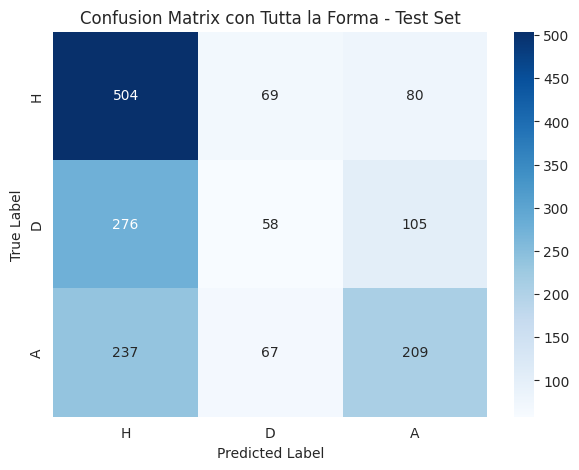


Classification Report con Tutta la Forma:
              precision    recall  f1-score   support

           H       0.50      0.77      0.60       653
           D       0.30      0.13      0.18       439
           A       0.53      0.41      0.46       513

    accuracy                           0.48      1605
   macro avg       0.44      0.44      0.42      1605
weighted avg       0.45      0.48      0.44      1605


--- Interpretazione con Tutta la Forma ---
L'aggiunta della forma gol (GS/GC L5) ha portato a un ULTERIORE MIGLIORAMENTO dell'accuracy (+3.8% rispetto al modello con solo forma punti).
L'accuracy complessiva raggiunge ora il 48.0%. Un buon passo avanti!
Confronta il nuovo Classification Report con i precedenti per vedere i cambiamenti specifici per classe (H/D/A).


In [18]:
# Cella 13: Riesecuzione Pipeline con Features Forma Punti e Gol

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("--- Riesecuzione Pipeline con Aggiunta Features Forma Punti e Gol ---")

# 1. SELEZIONE FEATURES (Includendo TUTTE le forme calcolate)
target_column = 'FTR'
# Aggiungiamo le nuove colonne di forma gol al set precedente
feature_columns_all_form = [
    'HomeTeam', 'AwayTeam', 'DayOfWeek',
    'HomeFormPts_L5', 'AwayFormPts_L5',
    'HomeFormGS_L5', 'HomeFormGC_L5',
    'AwayFormGS_L5', 'AwayFormGC_L5'
]

print(f"Target (y): {target_column}")
print(f"Features (X) con Tutta la Forma selezionate: {feature_columns_all_form}")

# Crea i DataFrame/Series per X e y (usando il df aggiornato con tutte le forme)
y = df[target_column]
X_pre_encoding_all_form = df[feature_columns_all_form]

# 2. CODIFICA ONE-HOT (sulle features categoriche)
categorical_features_all_form = X_pre_encoding_all_form.select_dtypes(include='object').columns
print(f"\nFeatures categoriche da codificare: {list(categorical_features_all_form)}")

X_encoded_all_form = pd.get_dummies(X_pre_encoding_all_form, columns=categorical_features_all_form, drop_first=False)

# Mantieni le colonne numeriche (DayOfWeek e TUTTE le Form)
numeric_features = X_pre_encoding_all_form.select_dtypes(include=np.number).columns
print(f"Features numeriche mantenute: {list(numeric_features)}")
print(f"\nDimensioni di X con Tutta la Forma dopo One-Hot Encoding: {X_encoded_all_form.shape}") # Dovrebbe avere 4 colonne in più del precedente (Cella 11)

# 3. DIVISIONE CRONOLOGICA TRAIN/TEST (stesso metodo)
test_size_percentage = 0.15
split_index = math.ceil(len(X_encoded_all_form) * (1 - test_size_percentage))

X_train_all_form = X_encoded_all_form.iloc[:split_index]
X_test_all_form = X_encoded_all_form.iloc[split_index:]
y_train_all_form = y.iloc[:split_index]
y_test_all_form = y.iloc[split_index:] # y_test è sempre lo stesso

print("\nDimensioni dei set con Tutta la Forma di addestramento e test:")
print(f"X_train_all_form shape: {X_train_all_form.shape}")
print(f"y_train_all_form shape: {y_train_all_form.shape}")
print(f"X_test_all_form shape: {X_test_all_form.shape}")
print(f"y_test_all_form shape: {y_test_all_form.shape}")

# 4. ADDESTRAMENTO E VALUTAZIONE MODELLO (Random Forest)
print("\nAddestramento Modello con Tutta la Forma (Random Forest)...")
# Usiamo gli stessi parametri del modello precedente per un confronto equo
rf_model_all_form = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model_all_form.fit(X_train_all_form, y_train_all_form)
print("Modello addestrato.")

print("\nEffettuando previsioni con Tutta la Forma sul Test Set...")
y_pred_all_form = rf_model_all_form.predict(X_test_all_form)

print("\nValutazione del Modello con Tutta la Forma sul Test Set:")
accuracy_all_form = accuracy_score(y_test_all_form, y_pred_all_form)
print(f"\nAccuracy con Tutta la Forma: {accuracy_all_form:.4f} ({(accuracy_all_form * 100):.2f}%)")

# Confronto con baseline e modello precedente
baseline_accuracy = 0.4243 # Accuracy senza forma (Cella 9 Corretta)
points_form_accuracy = 0.4424 # Accuracy con solo forma punti (Cella 11)
improvement_vs_baseline = accuracy_all_form - baseline_accuracy
improvement_vs_points_form = accuracy_all_form - points_form_accuracy

print(f"Accuracy Baseline (senza forma): {baseline_accuracy:.4f}")
print(f"Accuracy con Forma Punti:      {points_form_accuracy:.4f}")
print(f"Miglioramento vs Baseline:      {improvement_vs_baseline:+.4f} ({improvement_vs_baseline/baseline_accuracy*100:+.2f}%)")
print(f"Miglioramento vs Forma Punti:   {improvement_vs_points_form:+.4f} ({improvement_vs_points_form/points_form_accuracy*100:+.2f}%)")


print("\nConfusion Matrix con Tutta la Forma:")
labels = ['H', 'D', 'A']
cm_all_form = confusion_matrix(y_test_all_form, y_pred_all_form, labels=labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_all_form, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix con Tutta la Forma - Test Set')
plt.show()

print("\nClassification Report con Tutta la Forma:")
report_all_form = classification_report(y_test_all_form, y_pred_all_form, labels=labels)
print(report_all_form)

print("\n--- Interpretazione con Tutta la Forma ---")
if improvement_vs_points_form > 0.005: # Consideriamo un miglioramento > 0.5% rispetto all'ultimo step
    print(f"L'aggiunta della forma gol (GS/GC L5) ha portato a un ULTERIORE MIGLIORAMENTO dell'accuracy (+{improvement_vs_points_form*100:.1f}% rispetto al modello con solo forma punti).")
    print(f"L'accuracy complessiva raggiunge ora il {accuracy_all_form*100:.1f}%. Un buon passo avanti!")
elif improvement_vs_baseline > 0.01:
     print(f"L'aggiunta della forma gol non ha migliorato significativamente rispetto alla sola forma punti, ma il modello rimane migliore del baseline iniziale.")
else:
    print("L'aggiunta della forma gol non sembra aver portato benefici significativi rispetto al modello precedente.")

print("Confronta il nuovo Classification Report con i precedenti per vedere i cambiamenti specifici per classe (H/D/A).")

In [21]:
# Cella 14 (Rivista): Funzione per Predire la Prossima Giornata

import pandas as pd
import numpy as np
from datetime import datetime
# from tqdm.notebook import tqdm # Descommenta se vuoi le barre di progresso per .apply

print("--- Definizione Funzione di Previsione (Rivista) ---")

#---------------------------------------------------------------------
# FUNZIONI AUSILIARIE PER IL CALCOLO DELLA FORMA
# (Basate sulle logiche definite nelle celle precedenti)
#---------------------------------------------------------------------

def get_points(result):
    """Converte FTR in punti Home/Away."""
    if result == 'H': return 3, 0
    elif result == 'D': return 1, 1
    elif result == 'A': return 0, 3
    else: return np.nan, np.nan

def calculate_rolling_points(team, date, history_df_with_points, n_games=5):
    """Calcola i punti totali nelle ultime N partite giocate prima della data specificata."""
    team_history = history_df_with_points[(history_df_with_points['Date'] < date) &
                                          ((history_df_with_points['HomeTeam'] == team) | (history_df_with_points['AwayTeam'] == team))]
    last_n = team_history.sort_values(by='Date', ascending=False).head(n_games)
    if last_n.empty: return 0
    pts = 0
    # Assicurati che HomePoints/AwayPoints siano numerici, gestendo NaN se presenti (non dovrebbero esserci qui)
    for _, row in last_n.iterrows():
        if row['HomeTeam'] == team:
            pts += row.get('HomePoints', 0) # Usa .get con default 0 per sicurezza
        elif row['AwayTeam'] == team:
            pts += row.get('AwayPoints', 0)
    return pts

def calculate_rolling_avg_gs(team, date, history_df, n_games=5):
    """Calcola la media gol segnati (GS) nelle ultime N partite giocate prima della data specificata."""
    team_history = history_df[(history_df['Date'] < date) &
                              ((history_df['HomeTeam'] == team) | (history_df['AwayTeam'] == team))]
    last_n_games = team_history.sort_values(by='Date', ascending=False).head(n_games)
    if last_n_games.empty: return 0.0
    goals_scored = 0
    games_counted = 0
    for index, row in last_n_games.iterrows():
        if row['HomeTeam'] == team:
            goals_scored += row['FTHG']
        elif row['AwayTeam'] == team:
            goals_scored += row['FTAG']
        games_counted += 1
    return goals_scored / games_counted if games_counted > 0 else 0.0

def calculate_rolling_avg_gc(team, date, history_df, n_games=5):
    """Calcola la media gol concessi (GC) nelle ultime N partite giocate prima della data specificata."""
    team_history = history_df[(history_df['Date'] < date) &
                              ((history_df['HomeTeam'] == team) | (history_df['AwayTeam'] == team))]
    last_n_games = team_history.sort_values(by='Date', ascending=False).head(n_games)
    if last_n_games.empty: return 0.0
    goals_conceded = 0
    games_counted = 0
    for index, row in last_n_games.iterrows():
        if row['HomeTeam'] == team:
            goals_conceded += row['FTAG'] # Gol subiti in casa = FTAG
        elif row['AwayTeam'] == team:
            goals_conceded += row['FTHG'] # Gol subiti fuori = FTHG
        games_counted += 1
    return goals_conceded / games_counted if games_counted > 0 else 0.0

#---------------------------------------------------------------------
# FUNZIONE PRINCIPALE DI PREVISIONE
#---------------------------------------------------------------------

def predict_next_matchday(fixtures_list, history_df, model, train_columns_list):
    """
    Prevede i risultati per una lista di partite future.

    Args:
        fixtures_list (list): Lista di dizionari, ognuno con 'Date', 'HomeTeam', 'AwayTeam'.
        history_df (pd.DataFrame): DataFrame storico completo (deve contenere FTR, FTHG, FTAG).
        model: Il modello scikit-learn addestrato.
        train_columns_list (list): Lista nomi colonne usate per addestrare il modello (post encoding).

    Returns:
        pd.DataFrame: DataFrame con partite, features calcolate per verifica (opzionale), e previsioni.
    """
    if not fixtures_list:
        print("Nessuna partita fornita per la previsione.")
        return pd.DataFrame()

    print(f"Preparazione dati per {len(fixtures_list)} partite...")
    new_matches = pd.DataFrame(fixtures_list)
    try:
        new_matches['Date'] = pd.to_datetime(new_matches['Date'])
    except Exception as e:
        print(f"Errore conversione date: {e}. Formato richiesto es. 'YYYY-MM-DD'.")
        return pd.DataFrame()

    # Calcola DayOfWeek
    new_matches['DayOfWeek'] = new_matches['Date'].dt.dayofweek

    # Prepara history_df per calcolo punti (lo fa solo se necessario)
    history_df_with_points = history_df.copy()
    if 'HomePoints' not in history_df_with_points.columns or 'AwayPoints' not in history_df_with_points.columns :
        print("Calcolo colonne punti temporanee sullo storico...")
        points = history_df_with_points['FTR'].apply(get_points)
        history_df_with_points['HomePoints'] = points.apply(lambda x: x[0])
        history_df_with_points['AwayPoints'] = points.apply(lambda x: x[1])
        # Gestisci eventuali NaN risultanti da FTR non validi (improbabile ma sicuro)
        history_df_with_points.fillna({'HomePoints': 0, 'AwayPoints': 0}, inplace=True)


    # Calcola features di forma
    print("Calcolo features di forma per le nuove partite...")
    # tqdm.pandas(desc="Calcolo Forma") # Descommenta per barra progresso se tqdm è importato

    # Calcolo Punti Forma L5
    new_matches['HomeFormPts_L5'] = new_matches.apply(lambda row: calculate_rolling_points(row['HomeTeam'], row['Date'], history_df_with_points, n_games=5), axis=1)
    new_matches['AwayFormPts_L5'] = new_matches.apply(lambda row: calculate_rolling_points(row['AwayTeam'], row['Date'], history_df_with_points, n_games=5), axis=1)

    # Calcolo Gol Forma L5
    new_matches['HomeFormGS_L5'] = new_matches.apply(lambda row: calculate_rolling_avg_gs(row['HomeTeam'], row['Date'], history_df, n_games=5), axis=1)
    new_matches['HomeFormGC_L5'] = new_matches.apply(lambda row: calculate_rolling_avg_gc(row['HomeTeam'], row['Date'], history_df, n_games=5), axis=1)
    new_matches['AwayFormGS_L5'] = new_matches.apply(lambda row: calculate_rolling_avg_gs(row['AwayTeam'], row['Date'], history_df, n_games=5), axis=1)
    new_matches['AwayFormGC_L5'] = new_matches.apply(lambda row: calculate_rolling_avg_gc(row['AwayTeam'], row['Date'], history_df, n_games=5), axis=1)
    print("Features di forma calcolate.")

    # Seleziona colonne per encoding (quelle usate in training)
    feature_columns_to_encode = [
        'HomeTeam', 'AwayTeam', 'DayOfWeek',
        'HomeFormPts_L5', 'AwayFormPts_L5',
        'HomeFormGS_L5', 'HomeFormGC_L5',
        'AwayFormGS_L5', 'AwayFormGC_L5'
    ]
    # Assicurati che tutte le colonne esistano in new_matches prima di selezionare
    cols_present = [col for col in feature_columns_to_encode if col in new_matches.columns]
    X_new_pre_encoding = new_matches[cols_present]

    # Applica One-Hot Encoding
    categorical_features_new = X_new_pre_encoding.select_dtypes(include='object').columns
    if list(categorical_features_new): # Codifica solo se ci sono colonne categoriche
        X_new_encoded = pd.get_dummies(X_new_pre_encoding, columns=categorical_features_new, drop_first=False)
    else:
        X_new_encoded = X_new_pre_encoding # Nessuna codifica necessaria

    # Allinea le colonne a quelle usate nel training !! CRUCIALE !!
    X_new_aligned = X_new_encoded.reindex(columns=train_columns_list, fill_value=0)

    # Verifica opzionale: Assicurati che non ci siano NaN prima della previsione
    if X_new_aligned.isnull().any().any():
        print("ATTENZIONE: Trovati valori NaN nei dati preparati prima della previsione!")
        # Potresti volerli riempire con 0 o una media/mediana appropriata
        # X_new_aligned = X_new_aligned.fillna(0) # Esempio: riempire con 0

    print(f"Dimensioni dati nuovi dopo encoding e allineamento: {X_new_aligned.shape}")

    # Effettua le previsioni
    print("Effettuando le previsioni...")
    try:
        predictions = model.predict(X_new_aligned)
        probabilities = model.predict_proba(X_new_aligned)
    except Exception as e:
        print(f"Errore durante la previsione: {e}")
        print("Controlla la compatibilità dei dati (es. tipi, NaN) con il modello.")
        return pd.DataFrame()


    # Crea un DataFrame con i risultati
    results_df = new_matches[['Date', 'HomeTeam', 'AwayTeam']].copy()
    # Aggiungi le features calcolate per trasparenza (opzionale)
    results_df = pd.concat([results_df, new_matches[feature_columns_to_encode[2:]]], axis=1) # Aggiunge DayOfWeek e forme

    results_df['Predicted_FTR'] = predictions

    # Aggiungi le probabilità per ciascuna classe
    prob_cols = [f'Prob_{cls}' for cls in model.classes_]
    results_df[prob_cols] = np.round(probabilities, 3)

    print("Previsioni completate.")
    return results_df

# --- Esempio di Utilizzo ---
# Definisci le partite della prossima giornata (USA DATE E SQUADRE REALI!)
# Nota: La chiave 'Time' viene ignorata dalla funzione.
giornata_esempio = [
    {'Date': '2025-05-18', 'HomeTeam': 'Cagliari', 'AwayTeam': 'Venezia', 'Time': '20:45'},
    {'Date': '2025-05-18', 'HomeTeam': 'Fiorentina', 'AwayTeam': 'Bologna', 'Time': '20:45'},
    {'Date': '2025-05-17', 'HomeTeam': 'Genoa', 'AwayTeam': 'Atalanta', 'Time': '20:45'},
    {'Date': '2025-05-17', 'HomeTeam': 'Verona', 'AwayTeam': 'Como', 'Time': '18:00'},
    {'Date': '2025-05-18', 'HomeTeam': 'Inter', 'AwayTeam': 'Lazio', 'Time': '20:45'},
    {'Date': '2025-05-18', 'HomeTeam': 'Juventus', 'AwayTeam': 'Udinese', 'Time': '20:45'},
    {'Date': '2025-05-18', 'HomeTeam': 'Lecce', 'AwayTeam': 'Torino', 'Time': '20:45'},
    {'Date': '2025-05-18', 'HomeTeam': 'Monza', 'AwayTeam': 'Empoli', 'Time': '20:45'},
    {'Date': '2025-05-18', 'HomeTeam': 'Parma', 'AwayTeam': 'Napoli', 'Time': '20:45'},
    {'Date': '2025-05-18', 'HomeTeam': 'Roma', 'AwayTeam': 'Milan', 'Time': '20:45'}
]

# Assicurati che le variabili globali siano definite dalle celle precedenti:
# df: DataFrame storico completo e aggiornato
# rf_model_all_form: Modello Random Forest addestrato (con tutte le forme)
# X_train_all_form: DataFrame usato per addestrare (per ottenere la lista colonne)

try:
    train_col_names = X_train_all_form.columns.tolist()
    predictions_giornata = predict_next_matchday(giornata_esempio, df, rf_model_all_form, train_col_names)
    print("\n--- Previsioni Giornata Esempio ---")
    # Stampa il DataFrame completo o solo alcune colonne per leggibilità
    # print(predictions_giornata)
    print(predictions_giornata[['Date', 'HomeTeam', 'AwayTeam', 'Predicted_FTR', 'Prob_H', 'Prob_D', 'Prob_A']])

except NameError as e:
     print(f"\nERRORE: Una delle variabili necessarie (df, rf_model_all_form, X_train_all_form) non è definita.")
     print(f"Dettagli: {e}")
     print("Assicurati di aver eseguito correttamente tutte le celle precedenti, in particolare quelle che definiscono e addestrano il modello finale.")
except Exception as e:
     print(f"\nSi è verificato un errore imprevisto durante l'esecuzione: {e}")

--- Definizione Funzione di Previsione (Rivista) ---
Preparazione dati per 10 partite...
Calcolo colonne punti temporanee sullo storico...
Calcolo features di forma per le nuove partite...
Features di forma calcolate.
Dimensioni dati nuovi dopo encoding e allineamento: (10, 109)
Effettuando le previsioni...
Previsioni completate.

--- Previsioni Giornata Esempio ---
        Date    HomeTeam  AwayTeam Predicted_FTR  Prob_H  Prob_D  Prob_A
0 2025-05-18    Cagliari   Venezia             H    0.61    0.20    0.19
1 2025-05-18  Fiorentina   Bologna             H    0.53    0.29    0.18
2 2025-05-17       Genoa  Atalanta             A    0.30    0.20    0.50
3 2025-05-17      Verona      Como             A    0.17    0.28    0.55
4 2025-05-18       Inter     Lazio             H    0.42    0.39    0.19
5 2025-05-18    Juventus   Udinese             H    0.74    0.13    0.13
6 2025-05-18       Lecce    Torino             H    0.45    0.24    0.31
7 2025-05-18       Monza    Empoli             

In [22]:
# Cella 15: Visualizzazione Grafica Avanzata delle Previsioni

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Visualizzazione Grafica Previsioni Giornata ---")

# Assicurati che 'predictions_giornata' esista dalla cella precedente
if 'predictions_giornata' in locals() or 'predictions_giornata' in globals():

    # Seleziona e ordina le colonne per la visualizzazione
    cols_to_display = ['Date', 'HomeTeam', 'AwayTeam', 'Predicted_FTR', 'Prob_H', 'Prob_D', 'Prob_A']
    results_to_style = predictions_giornata[cols_to_display].copy() # Lavora su una copia

    # Arrotonda le probabilità se non già fatto (per la visualizzazione)
    prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
    #results_to_style[prob_cols] = results_to_style[prob_cols].round(3) # Già arrotondato nella funzione predict

    # Funzione per evidenziare la probabilità massima in una riga
    def highlight_max(s, props=''):
        # Assicurati che s contenga solo le colonne di probabilità
        probs = s[prob_cols]
        # Controlla che non siano tutte NaN o valori non numerici prima di trovare max
        if pd.api.types.is_numeric_dtype(probs) and not probs.isnull().all():
             max_val = probs.max()
             # Restituisci le proprietà per la cella che contiene il massimo, altrimenti stringa vuota
             return [props if v == max_val else '' for v in probs]
        else:
             return [''] * len(probs) # Restituisce stile vuoto se non ci sono numeri

    # Applica lo styling usando Pandas Styler
    styled_output = results_to_style.style \
        .format({ # Formatta le probabilità come percentuali
            'Prob_H': '{:.1%}',
            'Prob_D': '{:.1%}',
            'Prob_A': '{:.1%}',
            'Date': '{:%Y-%m-%d}' # Formatta la data
        }) \
        .bar(subset=prob_cols, color='lightblue', vmin=0, vmax=1, align='zero') \
        .apply(highlight_max, props='font-weight:bold; color:darkblue;', axis=1, subset=prob_cols) \
        .set_caption("Previsioni Modello Serie A (Acc: ~48%) - Forma Punti+Gol L5") \
        .set_properties(**{'text-align': 'center'}) \
        .hide(axis='index') # Nasconde l'indice numerico a sinistra

    # Mostra la tabella stilizzata (funziona bene in ambienti come Jupyter/Colab)
    display(styled_output)

else:
    print("ERRORE: Il DataFrame 'predictions_giornata' non è stato trovato.")
    print("Assicurati di aver eseguito la cella precedente (Cella 14) con successo.")

--- Visualizzazione Grafica Previsioni Giornata ---


Date,HomeTeam,AwayTeam,Predicted_FTR,Prob_H,Prob_D,Prob_A
2025-05-18,Cagliari,Venezia,H,61.0%,20.0%,19.0%
2025-05-18,Fiorentina,Bologna,H,53.0%,29.0%,18.0%
2025-05-17,Genoa,Atalanta,A,30.0%,20.0%,50.0%
2025-05-17,Verona,Como,A,17.0%,28.0%,55.0%
2025-05-18,Inter,Lazio,H,42.0%,39.0%,19.0%
2025-05-18,Juventus,Udinese,H,74.0%,13.0%,13.0%
2025-05-18,Lecce,Torino,H,45.0%,24.0%,31.0%
2025-05-18,Monza,Empoli,H,37.0%,27.0%,36.0%
2025-05-18,Parma,Napoli,A,40.0%,12.0%,48.0%
2025-05-18,Roma,Milan,H,47.0%,29.0%,24.0%
